In [1]:
!pip install python-dotenv google-generativeai


In [2]:
from dotenv import load_dotenv

In [ ]:

from datasets import load_dataset
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns


import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow. keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model



import os
import json
import time

# Gemini API
import google.generativeai as genai


In [2]:
# Set a random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
#  Load the Dataset
print("Loading the dataset: Tobi-Bueck/customer-support-tickets...")

try:
    ds = load_dataset("Tobi-Bueck/customer-support-tickets")
    print("Dataset loaded successfully.")

    # Convert train split to DataFrame
    df = ds["train"].to_pandas()

    # Verify required columns
    required_columns = ["body", "queue"]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found in dataset.")

    print("Required columns verified:", required_columns)
    print("Dataset shape (train):", df.shape)

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Loading the dataset: Tobi-Bueck/customer-support-tickets...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

aa_dataset-tickets-multi-lang-5-2-50-ver(…):   0%|          | 0.00/26.0M [00:00<?, ?B/s]

(…)set-tickets-german_normalized_50_5_2.csv: 0.00B [00:00, ?B/s]

dataset-tickets-multi-lang-4-20k.csv:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/61765 [00:00<?, ? examples/s]

Dataset loaded successfully.
Required columns verified: ['body', 'queue']
Dataset shape (train): (61765, 16)


# **1.Dataset Exploration**

In [4]:
print("\nBasic Dataset Information ")

# Dataset size
print(f"Total number of records in training data: {len(df)}")

# Display input and target columns
print("\nFirst 5 records (Input: body, Target: queue):")
print(df[["body", "queue"]].head())






Basic Dataset Information 
Total number of records in training data: 61765

First 5 records (Input: body, Target: queue):
                                                body                  queue
0  Sehr geehrtes Support-Team,\n\nich möchte eine...      Technical Support
1  Dear Customer Support Team,\n\nI am writing to...      Technical Support
2  Dear Customer Support Team,\n\nI hope this mes...  Returns and Exchanges
3  Dear Customer Support Team,\n\nI hope this mes...   Billing and Payments
4  Dear Support Team,\n\nI hope this message reac...    Sales and Pre-Sales


In [5]:
#  Explore Data Types
print("\nData Types of Key Fields ")
df.info()


Data Types of Key Fields 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61765 entries, 0 to 61764
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   subject   56466 non-null  object 
 1   body      61763 non-null  object 
 2   answer    48576 non-null  object 
 3   type      48587 non-null  object 
 4   queue     61765 non-null  object 
 5   priority  61765 non-null  object 
 6   language  61765 non-null  object 
 7   version   28587 non-null  float64
 8   tag_1     48587 non-null  object 
 9   tag_2     48528 non-null  object 
 10  tag_3     48356 non-null  object 
 11  tag_4     43990 non-null  object 
 12  tag_5     27636 non-null  object 
 13  tag_6     13225 non-null  object 
 14  tag_7     5968 non-null   object 
 15  tag_8     2472 non-null   object 
dtypes: float64(1), object(15)
memory usage: 7.5+ MB


In [6]:
#   Unique Queue Counts (Target Variable Analysis)
print("\nTarget Variable Analysis: 'queue' Distribution ")
queue_counts = df['queue'].value_counts()
num_classes = len(queue_counts)

print(f"Number of unique classes (queues): {num_classes}")
print("\nTop 10 Queue Distribution:")
print(queue_counts.head(10))


Target Variable Analysis: 'queue' Distribution 
Number of unique classes (queues): 52

Top 10 Queue Distribution:
queue
Technical Support                  14186
Product Support                     8960
Customer Service                    7420
IT Support                          5725
Billing and Payments                4874
Returns and Exchanges               2438
Service Outages and Maintenance     1912
Sales and Pre-Sales                 1490
Human Resources                      914
General Inquiry                      668
Name: count, dtype: int64


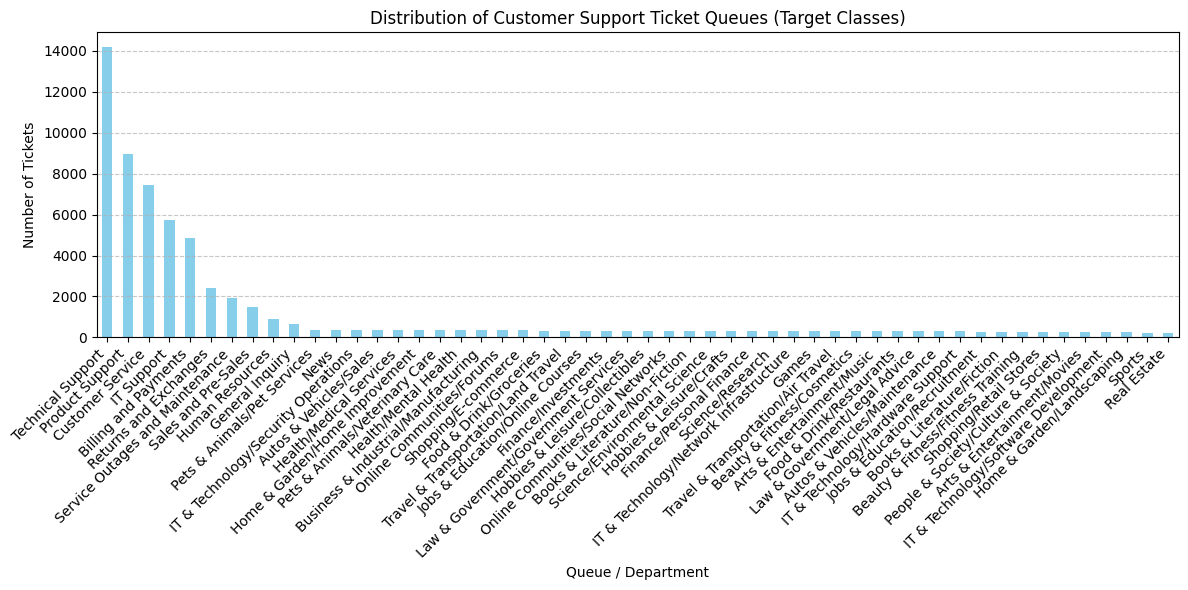

In [7]:
# Visualize the class distribution to check for imbalance
plt.figure(figsize=(12, 6))
queue_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Customer Support Ticket Queues (Target Classes)')
plt.xlabel('Queue / Department')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
#  Text Length Distribution (Input Variable Analysis)
print("\n Input Variable Analysis: 'body' Text Length ")

# Calculate the length of each ticket body in terms of words
df['body_length'] = df['body'].apply(lambda x: len(str(x).split()))

# Get descriptive statistics
length_stats = df['body_length'].describe(percentiles=[.50, .75, .90, .95, .99])
print("Body Text Length (in number of words) Statistics:")
print(length_stats)


 Input Variable Analysis: 'body' Text Length 
Body Text Length (in number of words) Statistics:
count    61765.000000
mean        57.362633
std         31.030969
min          1.000000
50%         57.000000
75%         82.000000
90%         93.000000
95%        102.000000
99%        138.000000
max        281.000000
Name: body_length, dtype: float64


Text(0, 0.5, 'Frequency')

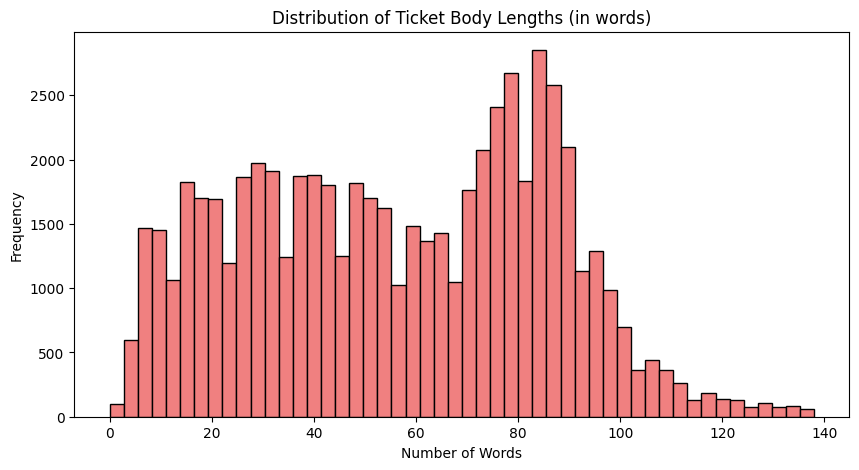

In [9]:
# Visualize the text length distribution
plt.figure(figsize=(10, 5))
plt.hist(df['body_length'], bins=50, color='lightcoral', edgecolor='black', range=(0, length_stats['99%'] if length_stats['99%'] < 500 else 500)) # Cap at 500 or 99th percentile for better visualization
plt.title('Distribution of Ticket Body Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')


Text Length Statistics:
count    61765.000000
mean        57.362633
std         31.030969
min          1.000000
50%         57.000000
95%        102.000000
max        281.000000
Name: text_length, dtype: float64


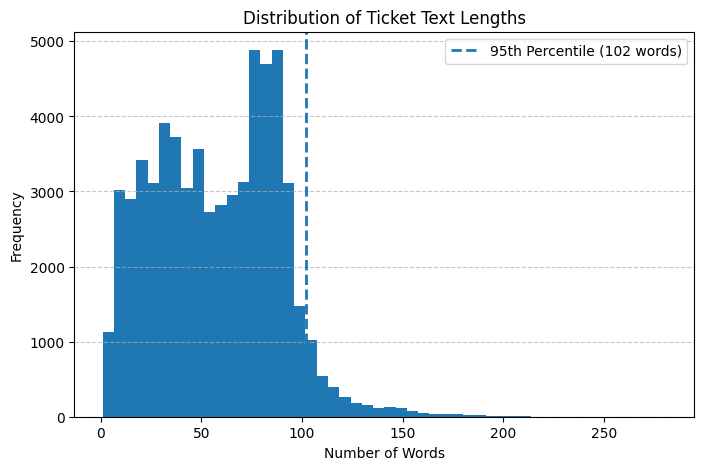

Selected MAX_LEN for padding: 102


In [10]:
df["text_length"] = df["body"].apply(lambda x: len(str(x).split()))

# Descriptive statistics including 95th percentile
length_stats = df["text_length"].describe(percentiles=[0.95])

print("\nText Length Statistics:")
print(length_stats)

# Plot text length distribution
plt.figure(figsize=(8,5))
plt.hist(df["text_length"], bins=50)
plt.title("Distribution of Ticket Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")

# Mark the 95th percentile (used for MAX_LEN)
max_len_95 = int(length_stats["95%"])
plt.axvline(
    max_len_95,
    linestyle="dashed",
    linewidth=2,
    label=f"95th Percentile ({max_len_95} words)"
)

plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

print(f"Selected MAX_LEN for padding: {max_len_95}")

# **2.Preprocessing, label encoding.**

In [11]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

print(" Text Preprocessing ")
df["clean_body"] = df["body"].apply(clean_text)

sample_index = 0
print("Original Text:", df["body"].iloc[sample_index])
print("Cleaned Text:", df["clean_body"].iloc[sample_index])


 Text Preprocessing 
Original Text: Sehr geehrtes Support-Team,\n\nich möchte einen gravierenden Sicherheitsvorfall melden, der gegenwärtig mehrere Komponenten unserer Infrastruktur betrifft. Betroffene Geräte umfassen Projektoren, Bildschirme und Speicherlösungen auf Cloud-Plattformen. Der Grund für die Annahme ist, dass der Vorfall eine potenzielle Datenverletzung im Zusammenhang mit einer Cyberattacke darstellt, was ein erhebliches Risiko für sensible Informationen und den laufenden Geschäftsbetrieb unserer Organisation bedeutet.\n\nUnsere initialen Untersuchungen haben ungewöhnliche Aktivitäten und Abweichungen bei den Geräten ergeben. Trotz der Umsetzung unserer standardisierten Behebungs- und Eindämmungsmaßnahmen konnte die Bedrohung bislang nicht vollständig eliminiert.
Cleaned Text: sehr geehrtes support team n nich m chte einen gravierenden sicherheitsvorfall melden der gegenw rtig mehrere komponenten unserer infrastruktur betrifft betroffene ger te umfassen projektoren bildsc

In [12]:
# Label Encoding for Queue

print("\nLabel Encoding for Queue ")

label_encoder = LabelEncoder()
df["encoded_queue"] = label_encoder.fit_transform(df["queue"])

QUEUE_MAPPING = dict(
    zip(label_encoder.classes_, range(len(label_encoder.classes_)))
)

NUM_CLASSES = len(label_encoder.classes_)

print(f"Total number of classes: {NUM_CLASSES}")
print("Label to Index Mapping Sample:", list(QUEUE_MAPPING.items())[:5])



Label Encoding for Queue 
Total number of classes: 52
Label to Index Mapping Sample: [('Arts & Entertainment/Movies', 0), ('Arts & Entertainment/Music', 1), ('Autos & Vehicles/Maintenance', 2), ('Autos & Vehicles/Sales', 3), ('Beauty & Fitness/Cosmetics', 4)]


In [13]:
# Tokenization and Sequence Preparation

print("\nTokenization and Padding/Truncation ")

MAX_WORDS = 15000  # Vocabulary size: consider the top 15,000 most frequent words
MAX_LEN = 102      # Sequence length: set to ~95th percentile word count

# Initialize Keras Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>")
# Fit on the cleaned text data
tokenizer.fit_on_texts(df['clean_body'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['clean_body'])

# Pad/Truncate sequences to MAX_LEN
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
y = df['encoded_queue'].values  # The target array

VOCAB_SIZE = min(MAX_WORDS, len(tokenizer.word_index) + 1)  # +1 for the 0 padding

print(f"Vocabulary Size (Unique Tokens): {VOCAB_SIZE}")
print(f"Maximum Sequence Length (MAX_LEN): {MAX_LEN}")
print("Shape of Final Input (X):", X.shape)



Tokenization and Padding/Truncation 
Vocabulary Size (Unique Tokens): 15000
Maximum Sequence Length (MAX_LEN): 102
Shape of Final Input (X): (61765, 102)


In [14]:
# Split Data into Train, Validation, and Test Sets

print("\nData Splitting (70/15/15) ")

#  Split into Training (70%) and Temporary Test (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

#  Split the Temporary Test (30%) into Validation (15%) and Final Test (15%)
# 0.5 of 30% = 15%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Total Samples: {len(X)}")
print(f"Training Samples (70%): {len(X_train)}")
print(f"Validation Samples (15%): {len(X_val)}")
print(f"Test Samples (15%): {len(X_test)}")

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)



Data Splitting (70/15/15) 
Total Samples: 61765
Training Samples (70%): 43235
Validation Samples (15%): 9265
Test Samples (15%): 9265
X_train shape: (43235, 102)
X_val shape: (9265, 102)
X_test shape: (9265, 102)


# **3. Build and train an RNN/LSTM model.**

In [15]:
VOCAB_SIZE = min(MAX_WORDS, len(tokenizer.word_index) + 1)     # Vocabulary Size (Unique Tokens)
MAX_LEN = 102          # Maximum Sequence Length (MAX_LEN)
NUM_CLASSES = 52        # Total number of classes (Queues)
EMBEDDING_DIM = 100     # A common choice for embedding dimension
LSTM_UNITS = 128        # Number of units in the LSTM layer

# Training Hyperparameters
BATCH_SIZE = 64
EPOCHS = 10
# Training will stop early if validation loss plateaus.


In [16]:
model = Sequential([
    tf.keras.layers.Input(shape=(MAX_LEN,)),
    Embedding(VOCAB_SIZE, 200),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 102, 200)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 102, 256)       │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 102, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 52)             │        13,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,547,636 (13.53 MB)

 Trainable params: 3,547,636 (13.53 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
MODEL_PATH = "/content/drive/MyDrive/GUVI/best_lstm_model.keras"


In [19]:
checkpoint_cb = ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stopping_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1
)


In [24]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_cb],
    verbose=1
)


Epoch 1/15
674/676 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6263 - loss: 1.0971
Epoch 1: val_accuracy did not improve from 0.57021
676/676 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.6264 - loss: 1.0968 - val_accuracy: 0.5316 - val_loss: 1.6008 - learning_rate: 5.0000e-04
Epoch 2/15
675/676 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6770 - loss: 0.9577
Epoch 2: val_accuracy did not improve from 0.57021
676/676 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.6770 - loss: 0.9576 - val_accuracy: 0.5453 - val_loss: 1.6555 - learning_rate: 5.0000e-04
Epoch 3/15
675/676 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7168 - loss: 0.8571
Epoch 3: val_accuracy did not improve from 0.57021

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
676/676 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.7168 - loss: 0.8570 - val_accuracy: 0.5537 - val_loss: 1.7242 - learning_rate: 5.0000e-04
Epoch 4/15
675/676 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7

# **4. Evaluate model, tune hyperparameters.**

In [25]:
#  Evaluate on Test Data (Accuracy)
print("\nEvaluating Model on Test Data")

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {test_accuracy:.4f}")



Evaluating Model on Test Data
Test Accuracy: 0.5356


In [26]:
# Precision, Recall, F1-Score

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=label_encoder.classes_
    )
)


290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

Classification Report:
                                        precision    recall  f1-score   support

           Arts & Entertainment/Movies       0.60      0.69      0.64        39
            Arts & Entertainment/Music       0.76      0.59      0.67        44
          Autos & Vehicles/Maintenance       0.60      0.55      0.57        44
                Autos & Vehicles/Sales       0.47      0.67      0.56        55
            Beauty & Fitness/Cosmetics       0.68      0.60      0.64        45
     Beauty & Fitness/Fitness Training       0.84      0.82      0.83        44
                  Billing and Payments       0.69      0.73      0.71       731
            Books & Literature/Fiction       0.97      0.84      0.90        44
        Books & Literature/Non-Fiction       0.68      0.71      0.69        48
   Business & Industrial/Manufacturing       0.73      0.71      0.72        52
                      Customer Service       0.37     

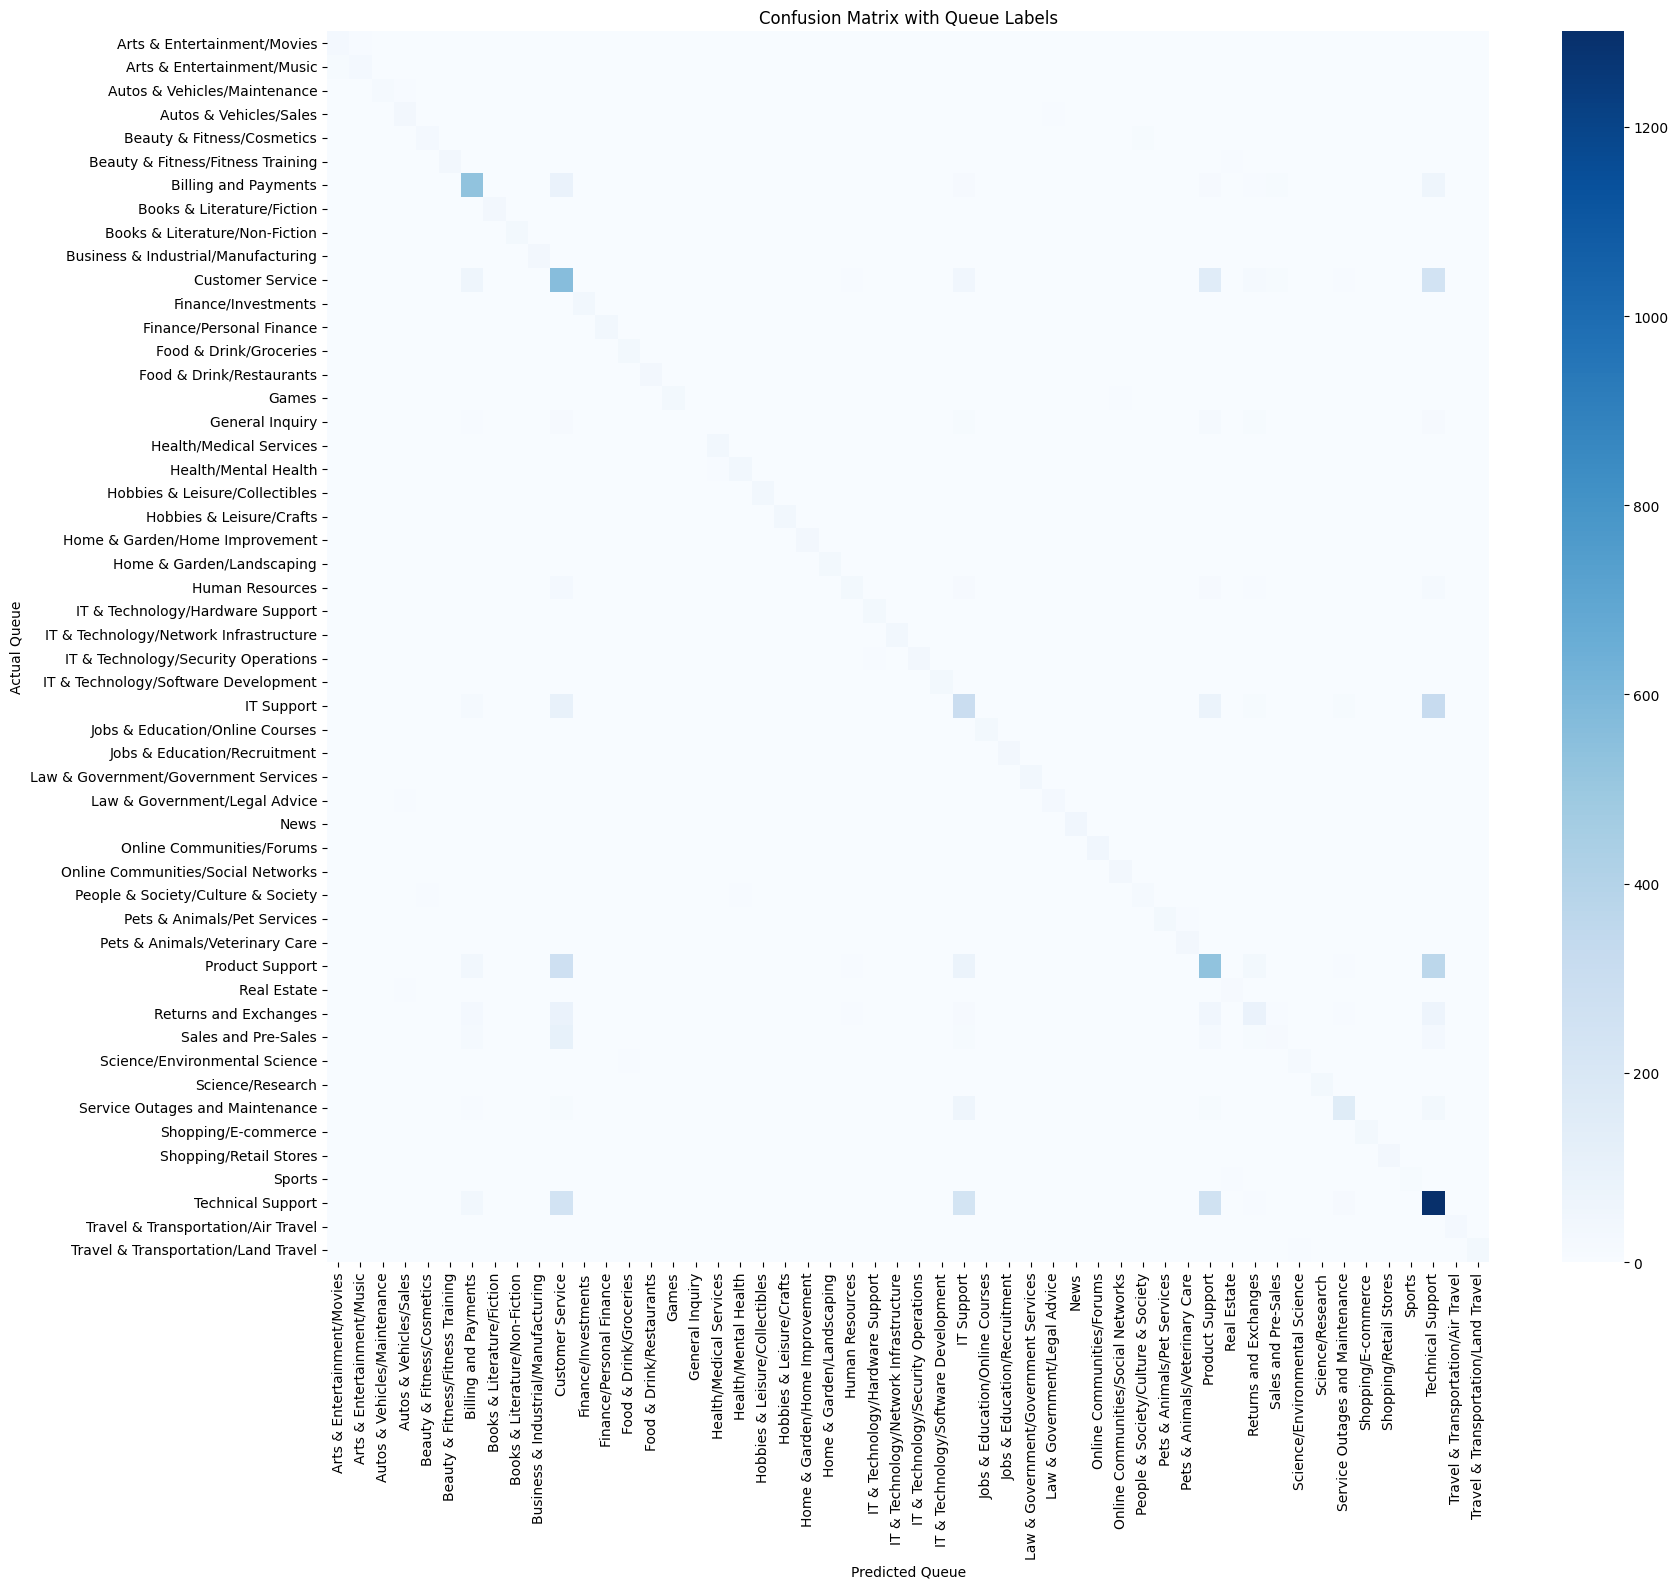

In [27]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

labels = label_encoder.classes_

plt.figure(figsize=(18, 16))
sns.heatmap(
    cm,
    xticklabels=labels,
    yticklabels=labels,
    cmap="Blues",
    cbar=True,
    fmt="d"
)

plt.title("Confusion Matrix with Queue Labels")
plt.xlabel("Predicted Queue")
plt.ylabel("Actual Queue")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [28]:
#tune hyperparameters
def build_and_train_model(
    embedding_dim,
    lstm_units,
    batch_size
):
    model = Sequential([
        tf.keras.layers.Input(shape=(MAX_LEN,)),
        Embedding(VOCAB_SIZE, embedding_dim),
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(lstm_units // 2)),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(NUM_CLASSES, activation="softmax")
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=batch_size,
        verbose=0
    )

    best_val_acc = max(history.history["val_accuracy"])
    return best_val_acc


In [29]:
embedding_dims = [100, 200]
lstm_units_list = [128, 256]
batch_sizes = [32, 64]


In [30]:
tuning_results = []

for emb in embedding_dims:
    for lstm_units in lstm_units_list:
        for batch in batch_sizes:
            val_acc = build_and_train_model(
                embedding_dim=emb,
                lstm_units=lstm_units,
                batch_size=batch
            )

            tuning_results.append({
                "embedding_dim": emb,
                "lstm_units": lstm_units,
                "batch_size": batch,
                "val_accuracy": val_acc
            })

            print(
                f"Embedding={emb}, LSTM={lstm_units}, "
                f"Batch={batch} -> Val Accuracy={val_acc:.4f}"
            )


Embedding=100, LSTM=128, Batch=32 -> Val Accuracy=0.4881
Embedding=100, LSTM=128, Batch=64 -> Val Accuracy=0.4541
Embedding=100, LSTM=256, Batch=32 -> Val Accuracy=0.4836
Embedding=100, LSTM=256, Batch=64 -> Val Accuracy=0.4271
Embedding=200, LSTM=128, Batch=32 -> Val Accuracy=0.5364
Embedding=200, LSTM=128, Batch=64 -> Val Accuracy=0.5252
Embedding=200, LSTM=256, Batch=32 -> Val Accuracy=0.4951
Embedding=200, LSTM=256, Batch=64 -> Val Accuracy=0.5020


In [31]:
tuning_df = pd.DataFrame(tuning_results)
tuning_df = tuning_df.sort_values("val_accuracy", ascending=False)

tuning_df


,embedding_dim,lstm_units,batch_size,val_accuracy
4,200,128,32,0.536427
5,200,128,64,0.525202
7,200,256,64,0.501997
6,200,256,32,0.495089
0,100,128,32,0.488073
2,100,256,32,0.483648
1,100,128,64,0.454074
3,100,256,64,0.427091


In [32]:
#Select best configuration
best_config = tuning_df.iloc[0]

BEST_EMBEDDING_DIM = int(best_config["embedding_dim"])
BEST_LSTM_UNITS = int(best_config["lstm_units"])
BEST_BATCH_SIZE = int(best_config["batch_size"])

print("Best Hyperparameters Selected:")
print(best_config)


Best Hyperparameters Selected:
embedding_dim    200.000000
lstm_units       128.000000
batch_size        32.000000
val_accuracy       0.536427
Name: 4, dtype: float64


In [33]:
#Train FINAL MODEL (used for Gemini integration)
final_model = Sequential([
    tf.keras.layers.Input(shape=(MAX_LEN,)),
    Embedding(VOCAB_SIZE, BEST_EMBEDDING_DIM),
    Bidirectional(LSTM(BEST_LSTM_UNITS, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(BEST_LSTM_UNITS // 2)),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation="softmax")
])

final_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = final_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=BEST_BATCH_SIZE,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_cb],
    verbose=1
)


Epoch 1/15
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2355 - loss: 2.4610
Epoch 1: val_accuracy did not improve from 0.57021
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.2355 - loss: 2.4609 - val_accuracy: 0.3201 - val_loss: 2.0589 - learning_rate: 0.0010
Epoch 2/15
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3327 - loss: 1.9930
Epoch 2: val_accuracy did not improve from 0.57021
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.3327 - loss: 1.9930 - val_accuracy: 0.3513 - val_loss: 1.8557 - learning_rate: 0.0010
Epoch 3/15
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3945 - loss: 1.7350
Epoch 3: val_accuracy did not improve from 0.57021
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.3945 - loss: 1.7349 - val_accuracy: 0.4192 - val_loss: 1.7083 - learning_rate: 0.0010
Epoch 4/15
1350/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4742 - loss: 1.4785
Epoch 4: val_accuracy did not improve from 0.57021
1352/

In [35]:
#Save & load best model
final_model = tf.keras.models.load_model("/content/drive/MyDrive/GUVI/best_lstm_model.keras")


In [36]:
test_loss, test_accuracy = final_model.evaluate(
    X_test,
    y_test,
    verbose=0
)

print(f"Final Test Accuracy: {test_accuracy:.4f}")

Final Test Accuracy: 0.5880


In [37]:
y_pred_probs = final_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print(
    classification_report(
        y_test,
        y_pred,
        target_names=label_encoder.classes_
    )
)


290/290 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
                                        precision    recall  f1-score   support

           Arts & Entertainment/Movies       0.60      0.82      0.70        39
            Arts & Entertainment/Music       0.90      0.82      0.86        44
          Autos & Vehicles/Maintenance       0.68      0.64      0.66        44
                Autos & Vehicles/Sales       0.76      0.80      0.78        55
            Beauty & Fitness/Cosmetics       0.93      0.91      0.92        45
     Beauty & Fitness/Fitness Training       0.88      0.95      0.91        44
                  Billing and Payments       0.80      0.71      0.75       731
            Books & Literature/Fiction       0.93      0.91      0.92        44
        Books & Literature/Non-Fiction       0.71      0.85      0.77        48
   Business & Industrial/Manufacturing       0.90      0.83      0.86        52
                      Customer Service       0.42      0.50      0.46      11

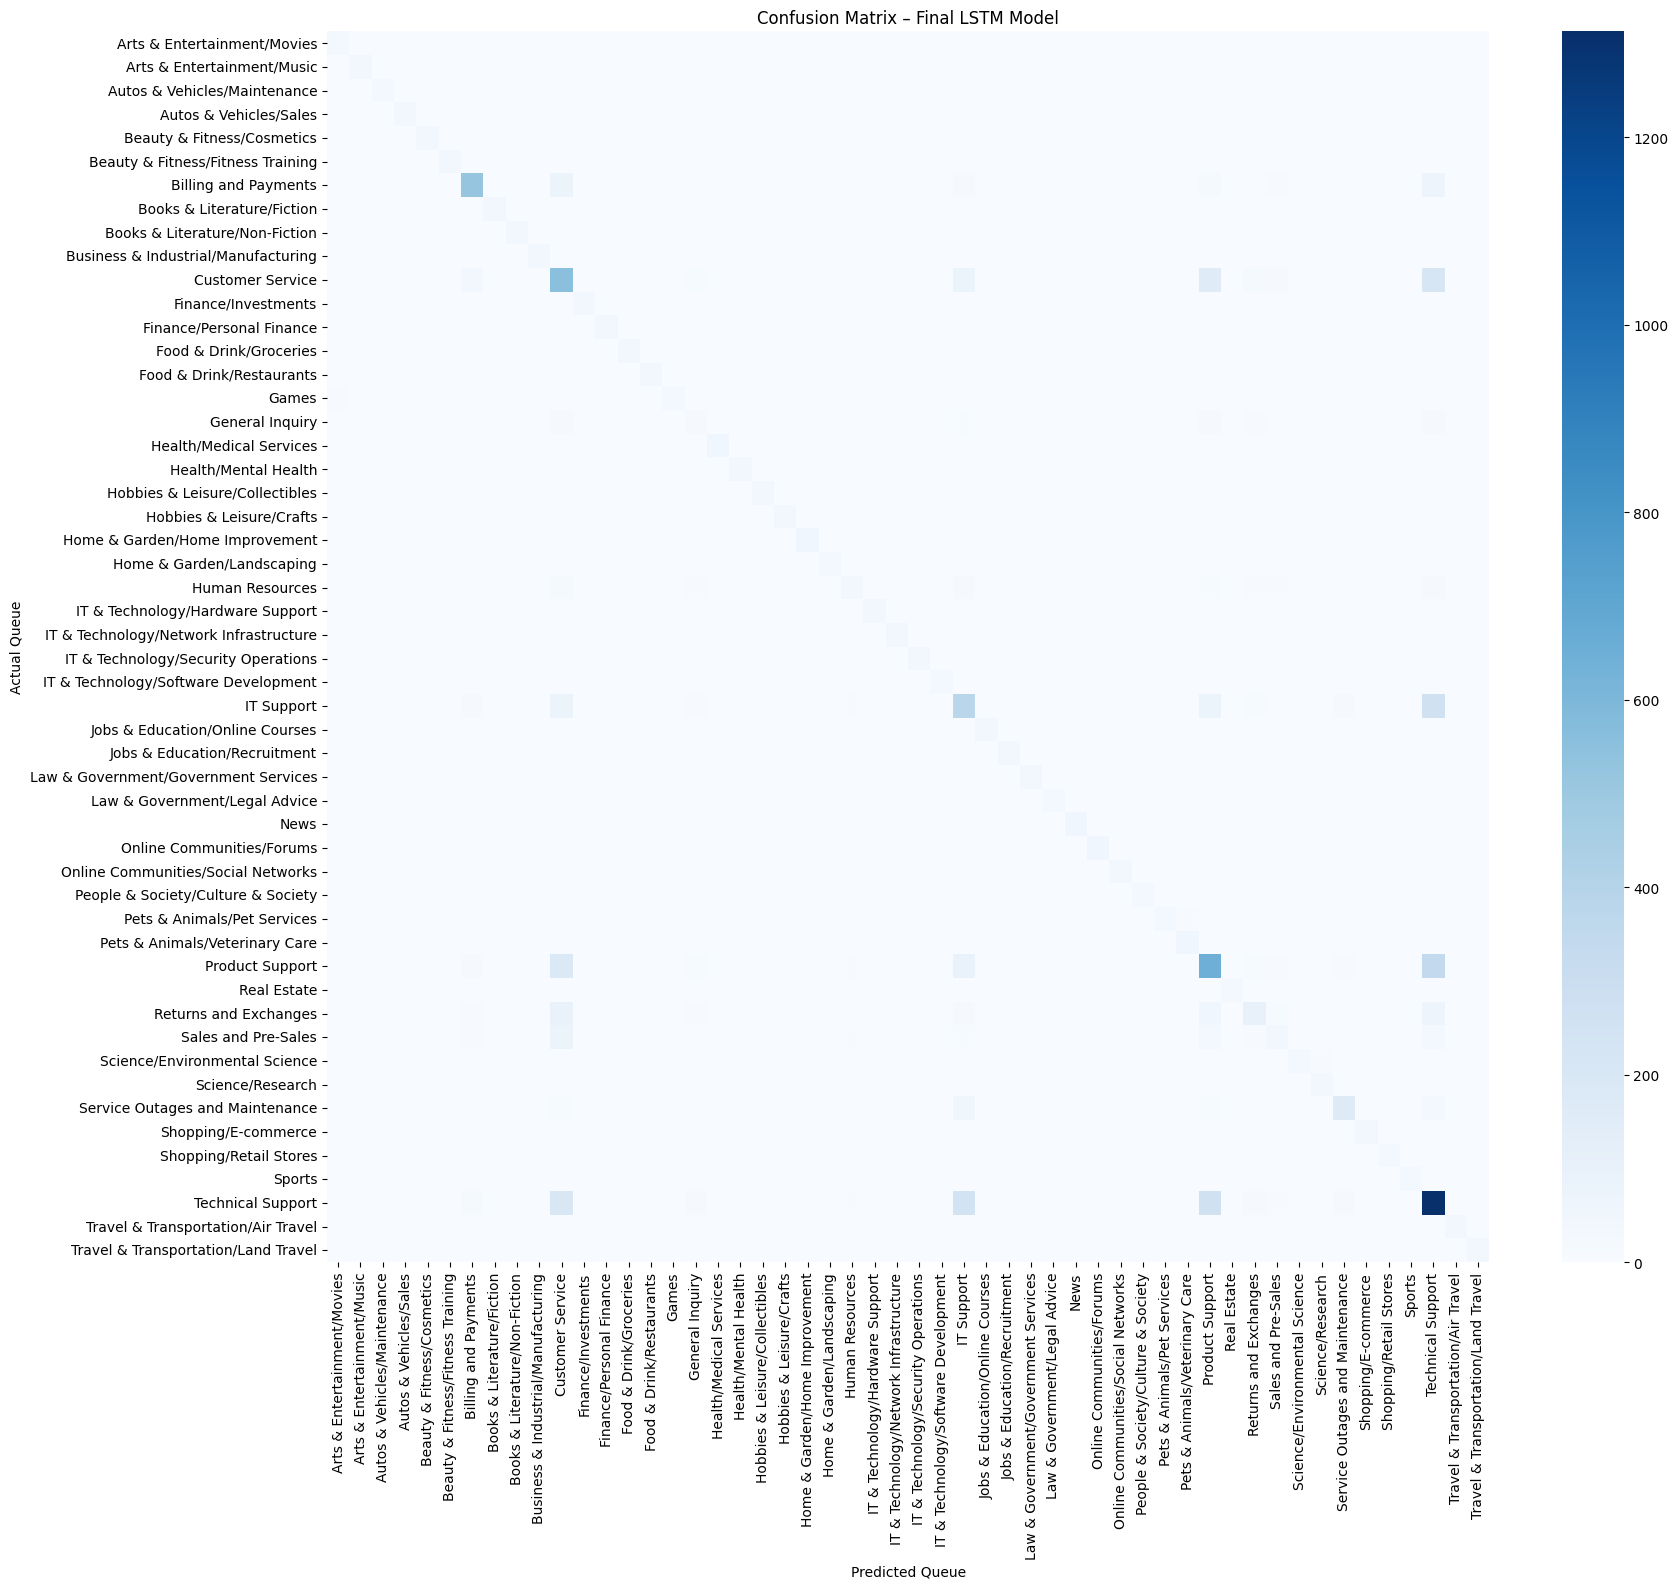

In [38]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(18, 16))
sns.heatmap(
    cm,
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cmap="Blues",
    fmt="d"
)

plt.title("Confusion Matrix – Final LSTM Model")
plt.xlabel("Predicted Queue")
plt.ylabel("Actual Queue")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [39]:
metrics = {
    "test_accuracy": test_accuracy
}

with open("/content/drive/MyDrive/GUVI/final_metrics.json", "w") as f:
    json.dump(metrics, f)


# **5. Integrate the Gemini API for automatic replies.**

In [ ]:
from google import genai
import os


# --- Configuration and Initialization ---
load_dotenv()

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
client = genai.Client()


In [41]:
def predict_queue(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding="post")
    pred = final_model.predict(padded)
    label_index = np.argmax(pred)
    return label_encoder.inverse_transform([label_index])[0]


In [48]:
def generate_gemini_reply(ticket_text, predicted_queue):
    prompt = f"""
You are a professional customer support assistant.

Customer Ticket:
\"\"\"{ticket_text}\"\"\"

Predicted Department:
{predicted_queue}

Instructions:
- Write a short, polite, and empathetic reply.
- Acknowledge the customer's issue.
- Assure the customer that the issue will be handled.
- Do NOT include names, signatures, or placeholders.
- Do NOT include company name.
- End the reply professionally without sign-off.
"""
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt
    )
    return response.text.strip()


In [49]:
sample_ticket = df["body"].iloc[5]

print("Customer Ticket:\n", sample_ticket)
print("\nPredicted Queue:", predict_queue(sample_ticket))
print("\nGenerated Reply:\n")
print(generate_gemini_reply(sample_ticket, predict_queue(sample_ticket)))


Customer Ticket:
 Dear Customer Support,\n\nI hope this message reaches you in good health. I am eager to learn more about the features of one of your products. Would you be able to share comprehensive details about its functionalities, specifications, and any distinctive characteristics it may possess? Additionally, if there are user manuals, tutorials, or demonstration videos available, I would be grateful if you could provide those resources. Gaining a thorough understanding of the features will assist me in making an informed decision regarding the product.\n\nThank you very much for your assistance. I look forward to your prompt reply.\n\nBest regards
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

Predicted Queue: Technical Support

Generated Reply:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Thank you for reaching out to us. We understand you are seeking comprehensive details about a product's functionalities, specifications, distinctive characteristics, and available resources such as user m

In [50]:
user_ticket = input("Enter customer ticket: ")

predicted_queue = predict_queue(user_ticket)
reply = generate_gemini_reply(user_ticket, predicted_queue)

print("Predicted Queue:", predicted_queue)
print("\nGenerated Reply:\n", reply)


Enter customer ticket: how to pay bill?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Queue: Billing and Payments

Generated Reply:
 I understand you're looking for information on how to pay your bill. We'll be happy to assist you with the payment process and provide all the necessary details.


In [51]:
import pickle
import os

SAVE_DIR = "/content/drive/MyDrive/GUVI"
os.makedirs(SAVE_DIR, exist_ok=True)

with open(f"{SAVE_DIR}/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open(f"{SAVE_DIR}/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("Tokenizer and LabelEncoder saved successfully.")


Tokenizer and LabelEncoder saved successfully.
